In [64]:
# LIBRARIES

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [133]:
# FUNCTIONS

def calculate_sma(df, window):
    return df['Close'].rolling(window=window).mean()

def calculate_macd(df):
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_rsi(df):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(df):
    middle_bb = df['Close'].rolling(window=20).mean()
    upper_bb = middle_bb + 2 * df['Close'].rolling(window=20).std()
    lower_bb = middle_bb - 2 * df['Close'].rolling(window=20).std()
    return middle_bb, upper_bb, lower_bb

def calculate_stochastic_oscillator(df):
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    slowk = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    slowd = slowk.rolling(window=3).mean()
    return slowk, slowd

def generate_trading_signals(df):

    # Calculate Simple Moving Averages (SMA)
    df['SMA_50'] = calculate_sma(df, 50)
    df['SMA_200'] = calculate_sma(df, 200)

    # Calculate other technical indicators
    df['RSI'] = calculate_rsi(df)
    df['MiddleBB'], df['UpperBB'], df['LowerBB'] = calculate_bollinger_bands(df)
    df['SlowK'], df['SlowD'] = calculate_stochastic_oscillator(df)

    # Generate trading signals

    df['SMA_Signal'] = np.where(df['SMA_50'] > df['SMA_200'], 1, 0)
    
    macd, signal = calculate_macd(df)
    df['MACD_Signal'] = np.where((macd > signal.shift(1)) & (macd.shift(1) < signal), 1, 0)
    
    df['RSI_Signal'] = np.where(df['RSI'] < 30, 1, 0)
    df['RSI_Signal'] = np.where(df['RSI'] > 70, -1, df['RSI_Signal'])
    
    df['BB_Signal'] = np.where(df['Close'] < df['LowerBB'], 1, 0)
    df['BB_Signal'] = np.where(df['Close'] > df['UpperBB'], -1, df['BB_Signal'])
    
    df['Stochastic_Signal'] = np.where((df['SlowK'] < 20) & (df['SlowD'] < 20), 1, 0)
    df['Stochastic_Signal'] = np.where((df['SlowK'] > 80) & (df['SlowD'] > 80), -1, df['Stochastic_Signal'])

    # Summing the values of each individual signal column
    df['Combined_Signal'] = df[['SMA_Signal', 'MACD_Signal', 'RSI_Signal', 'BB_Signal', 'Stochastic_Signal']].sum(axis=1)

def plot_trading_signals(df):
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 5 ), sharex=True)

    # Plotting Closing Prices
    axes[0].plot(df_last['Close'], label='Closing Price', color='purple')
    axes[0].set_ylabel('Price')
    axes[0].set_title('Stock Price')
    axes[0].legend()


    # Plotting Combined Signal
    axes[1].plot(df_last.index, df_last['Combined_Signal'], label='Combined Signal', color='yellow', linewidth=1.5)
    axes[1].set_ylabel('Combined Signal')
    axes[1].set_title('Combined Signal')
    axes[1].legend()

    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_combined_signals(df):
    
    # Create a figure
    fig = go.Figure()

    # Add close price trace
    fig.add_trace(go.Scatter(
        x=df_last_month.index, y=df_last_month['Close'], 
        mode='lines', 
        name='Closing Price', 
        line=dict(color='lightcoral', width=2)
    ))

    # Add buy signals
    buy_signals = df_last_month[df_last_month['Combined_Signal'] >= 2]
    fig.add_trace(go.Scatter(
        x=buy_signals.index, y=buy_signals['Close'], 
        mode='markers', 
        marker=dict(symbol='triangle-up', size=10, color='lightgreen'), 
        name='Buy Signal'
    ))

    # Add sell signals
    sell_signals = df_last_month[df_last_month['Combined_Signal'] <= -2]
    fig.add_trace(go.Scatter(
        x=sell_signals.index, y=sell_signals['Close'], 
        mode='markers', 
        marker=dict(symbol='triangle-down', size=10, color='lightsalmon'), 
        name='Sell Signal'
    ))

    # Add combined signal trace
    fig.add_trace(go.Scatter(
        x=df_last_month.index, y=df_last_month['Combined_Signal'], 
        mode='lines', 
        name='Combined Signal', 
        line=dict(color='deepskyblue', width=2), 
        yaxis='y2'
    ))

    # Update layout for secondary y-axis
    fig.update_layout(
        title=f'{ticker}: Stock Price and Combined Trading Signal (Last Month)',
        xaxis=dict(title='Date', gridcolor='gray', gridwidth=0.5),
        yaxis=dict(title='Price', side='left', gridcolor='gray', gridwidth=0.5),
        yaxis2=dict(title='Combined Signal', overlaying='y', side='right', showgrid=False),
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(0,0,0,0)'),
        hovermode='x unified'
    )

    fig.show()


def calculate_short_term_indicators(df):
    # Compute MACD
    def calculate_macd(df):
        short_ema = df['Close'].ewm(span=12, adjust=False).mean()
        long_ema = df['Close'].ewm(span=26, adjust=False).mean()
        macd_line = short_ema - long_ema
        signal_line = macd_line.ewm(span=9, adjust=False).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram

    # Compute ATR
    def calculate_atr(df, period=14):
        high_low = df['High'] - df['Low']
        high_close = np.abs(df['High'] - df['Close'].shift(1))
        low_close = np.abs(df['Low'] - df['Close'].shift(1))
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = true_range.rolling(window=period).mean()
        return atr

    # Compute OBV
    def calculate_obv(df):
        obv = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 
                       np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0)).cumsum()
        return pd.DataFrame(obv, index=df.index, columns=['OBV'])

    # Compute all indicators
    macd_line, signal_line, histogram = calculate_macd(df)
    atr = calculate_atr(df)
    obv = calculate_obv(df)

    # Create signals
    df['MACD_Signal'] = np.where(macd_line > signal_line, 1, 0)  # Bullish when MACD line crosses above signal line
    df['ATR_Signal'] = np.where(df['Close'] > df['Close'].shift(1) + atr, 1, 0)  # Bullish when close > previous close + ATR
    df['OBV_Signal'] = np.where(obv['OBV'] > obv['OBV'].shift(1), 1, 0)  # Bullish when OBV is increasing
    
    df.dropna(inplace=True)
    
    # Summing the values of each individual signal column
    df['Short Term'] = df[['MACD_Signal', 'ATR_Signal', 'OBV_Signal']].sum(axis=1)

    # Drop unnecessary columns
    df = df.drop(columns=['Open', 'High', 'Low','Adj Close', 'Volume', 'SMA_50',
       'SMA_200', 'RSI', 'MiddleBB', 'UpperBB', 'LowerBB', 'SlowK', 'SlowD',
       'SMA_Signal', 'RSI_Signal', 'BB_Signal',
       'Stochastic_Signal','MACD_Signal', 'ATR_Signal', 'OBV_Signal'])     
    
    # Rename the column
    df.rename(columns={'Combined_Signal': 'Long Term'}, inplace=True)

    # Reorder the columns
    df = df[['Close','Long Term', 'Short Term', ]]

    

    return df


def compare_signals(df):
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 5), sharex=True)

    # Plotting Closing Prices
    axes[0].plot(df.index, df['Close'], label='Closing Price', color='purple')
    axes[0].set_ylabel('Price')
    axes[0].set_title('Stock Price')
    axes[0].legend()

    # Plotting Long Term and Short Term signals
    axes[1].plot(df.index, df['Long Term'], label='Long Term', marker='o', linestyle='-', color='green')
    axes[1].plot(df.index, df['Short Term'], label='Short Term', marker='o', linestyle='-', color='red')
    axes[1].set_ylabel('Signal')
    axes[1].set_title('Long Term vs Short Term Signals')
    axes[1].legend()

    plt.xlabel('Date')
    plt.grid(True)
    plt.show()



In [66]:
# STOCK MARKET DATA

ticker = 'NVDA'  
df = yf.download(ticker, start='2022-01-01', end='2025-01-01')

[*********************100%%**********************]  1 of 1 completed


In [70]:
# Generate trading signals
generate_trading_signals(df)



In [73]:
# Last month trading signals

# Step 1: Select the last 30 days
last_30_days = df[['Close', 'Combined_Signal','Stochastic_Signal']].tail(30)

# Step 2: Apply the Boolean condition to filter rows where 'Combined_Signal' is not 0
filtered_days = last_30_days[last_30_days['Combined_Signal'] != 0]

# Display the filtered rows
filtered_days.tail(5)


,Close,Combined_Signal,Stochastic_Signal
Date,,,
2024-05-03,887.890015,1,0
2024-05-09,887.469971,1,0
2024-05-14,913.559998,-1,-1
2024-05-15,946.299988,-1,-1
2024-05-17,924.789978,1,0


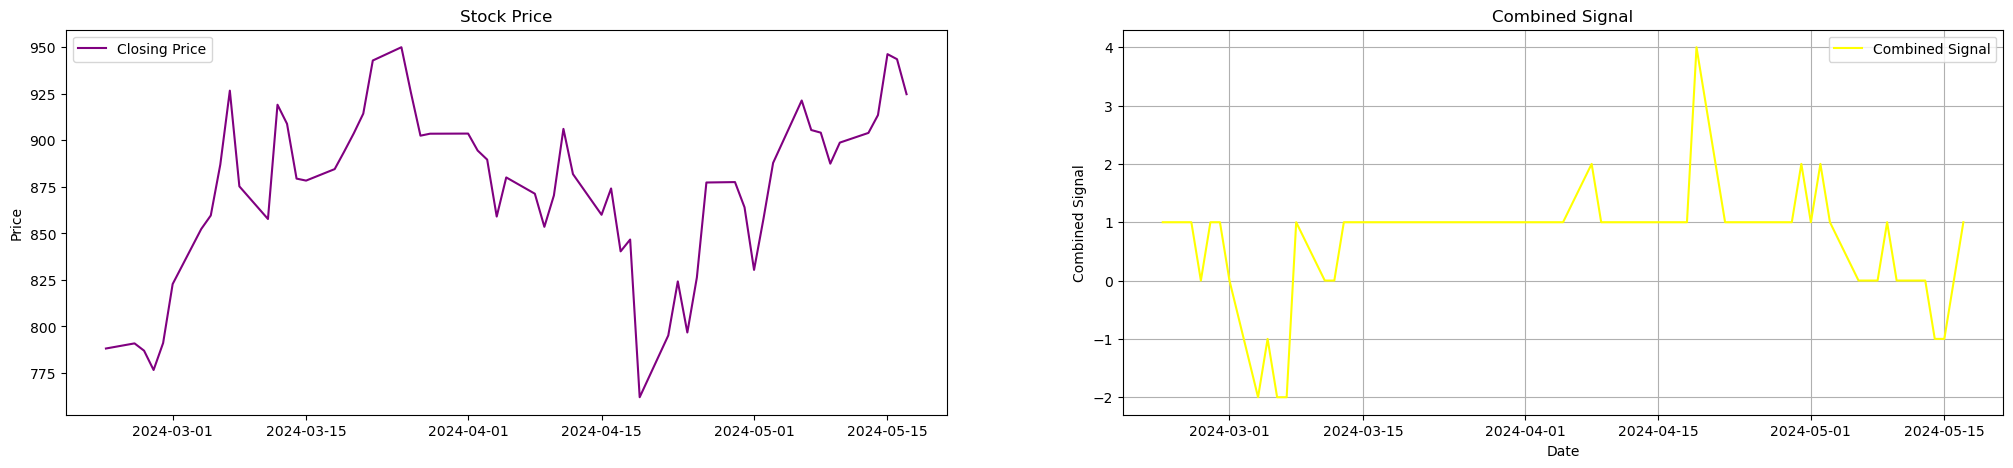

In [137]:
# Trading Signals Graph

plot_trading_signals(df.tail(60))

In [138]:
# Stock Price and Combined Trading Signal (Last Month)

df_last_days = df.tail(20)  


plot_combined_signals(df_last_days)

# Write the figure to an HTML file
# fig.write_html(ticker+"_interactive_plot.html")

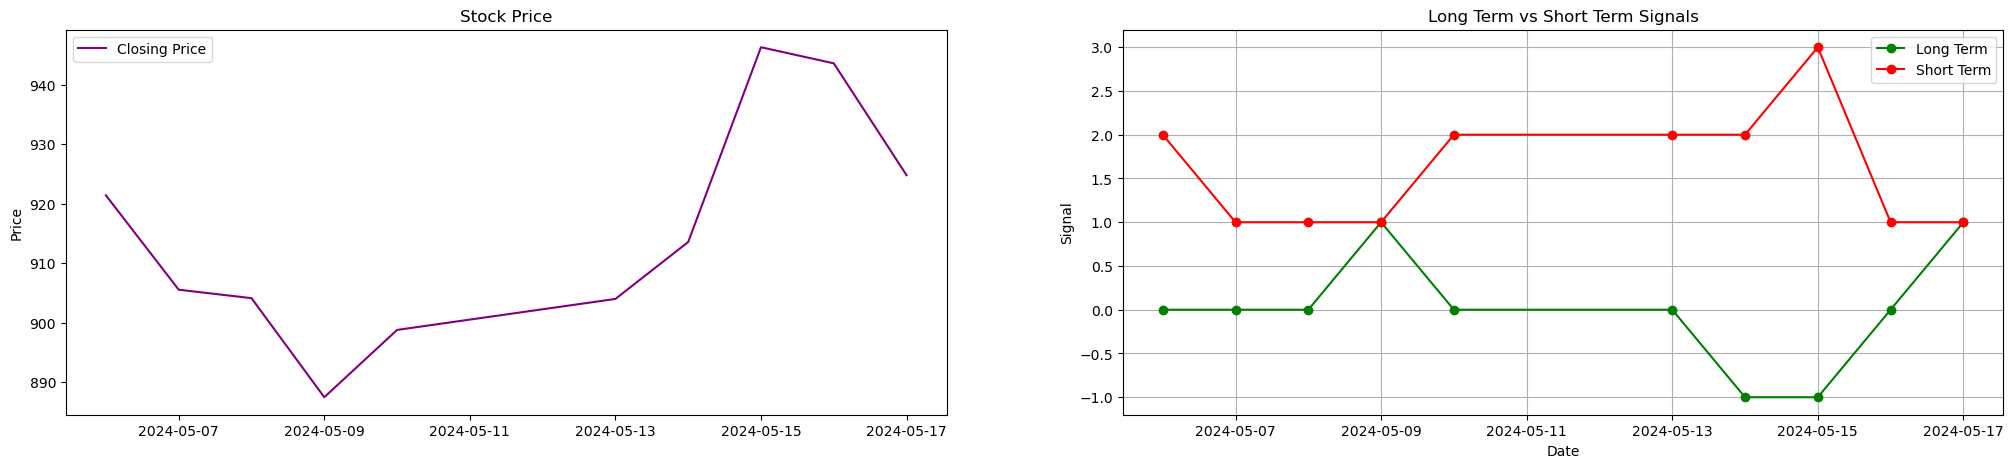

In [144]:
# Compare short term and long term signals

df_term = calculate_short_term_indicators(df)

compare_signals(df_term.tail(10))
